# Feature Engineering
### Video 3: Feature Transformation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
import os

In [2]:
# read data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_val = pd.read_csv('validation.csv')

In [3]:
df_train.head()

,SKU_ID,Date,Page_traffic,Revenue($),Unit_price,Units_sold,Segment,1_Star_Rating,2_Star_Rating,3_Star_Rating,...,Sum of Spend,Online_Clicks,Online_Cost,Online_Impressions,num_unique_campaigns,Clicks_video,Cost_video,Impressions_video,num_unique_campaigns_offline,Units_sold>1000
0,SKU732,2022-08-13,3260.0,37006,24.703605,1498,Makeup,82.0,64.0,180.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1
1,SKU1506,2021-06-12,3729.0,25316,22.226514,1139,Makeup,31.0,15.0,41.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1
2,SKU840,2022-10-29,2675.0,32454,25.574468,1269,Makeup,19.0,14.0,37.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1
3,SKU1387,2022-03-19,6281.0,36238,20.971065,1728,Makeup,25.0,18.0,62.0,...,408.036474,917.0,2654.489552,133688.0,4.0,5744.0,63978.2,6594469.0,2.0,1
4,SKU1183,2021-01-23,131.0,0,20.099526,0,Skincare,23.0,21.0,45.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0


In [4]:
# Encoding
df_train = pd.get_dummies(df_train, columns = ['Segment'], prefix = 'Segment', drop_first = True)
df_val = pd.get_dummies(df_val, columns = ['Segment'], prefix = 'Segment', drop_first = True)
df_test = pd.get_dummies(df_test, columns = ['Segment'], prefix = 'Segment', drop_first = True)

In [6]:
# Function for model performance
def check_model_performance(df_train,df_val,model=None):
    if model is None:
        model = GradientBoostingClassifier(max_depth=9,
                                           min_samples_leaf=30,
                                           n_estimators=50,
                                           random_state=42)
    x_train = df_train.drop(['SKU_ID','Date','Revenue($)','Units_sold','Units_sold>1000'],axis=1)
    y_train = df_train['Units_sold>1000']
    x_val = df_val.drop(['SKU_ID','Date','Revenue($)','Units_sold','Units_sold>1000'],axis=1)
    y_val = df_val['Units_sold>1000']
    model.fit(x_train,y_train)
    
    train_score = f1_score(y_train,model.predict(x_train))
    val_score = f1_score(y_val,model.predict(x_val))
    
    print(f'Performance on Train Data: {train_score}')
    print(f'Performance on Validation Data: {val_score}')

In [7]:
check_model_performance(df_train,df_val)

Performance on Train Data: 0.9389954986969913
Performance on Validation Data: 0.8909952606635071


In [8]:
# Function to handle outliers
def handle_train_outliers(data,col_name):
    # calculate IQR
    perc_25, perc_75 = np.percentile(data[col_name],[25,75])
    iqr = perc_75 - perc_25
    
    # Check for outliers
    outlier_checker = lambda x: (x > (perc_75 + 1.5*iqr)) or (x > (perc_25 - 1.5*iqr))
    is_outlier = data[col_name].apply(outlier_checker)
    
    # Visualize the outliers
    plt.figure(figsize=(5,5))
    
    sns.boxplot(data=data,x=col_name)
    plt.title(f'Box Plot for {col_name}, Outlier Count: {sum(is_outlier)}')
    plt.show()
    plt.close()
    
    return perc_25,perc_75,data[col_name].clip(lower=perc_25-1.5*iqr,upper=perc_75+1.5*iqr).values

In [12]:
# Handle outliers in test dataset
def handle_outliers(data,col_name,perc_25,perc_75):
    iqr = perc_75 - perc_25
    
    return data[col_name].clip(lower=perc_25-1.5*iqr,upper=perc_75+1.5*iqr).values
    

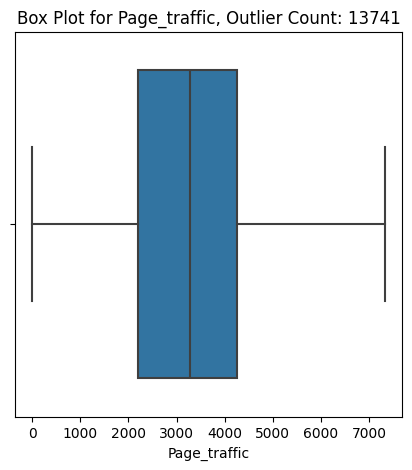

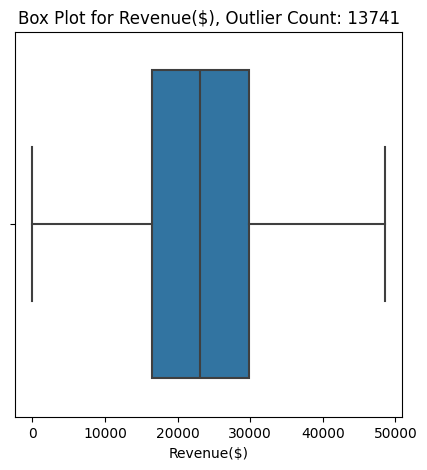

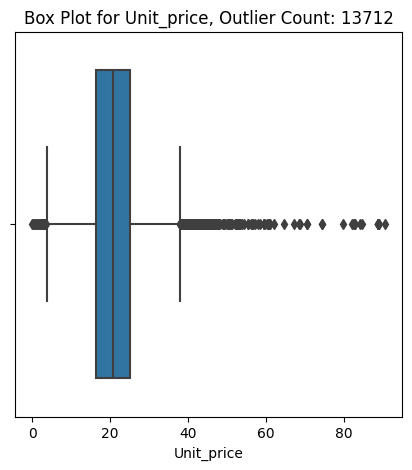

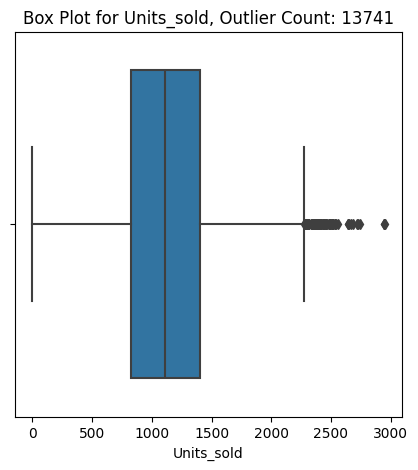

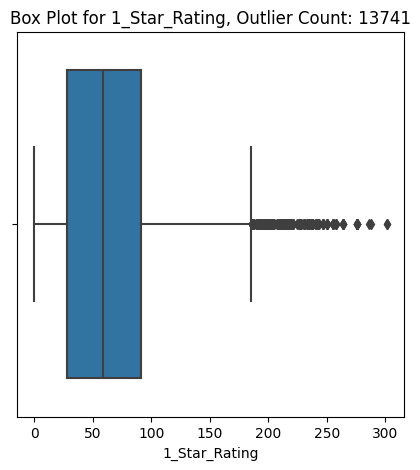

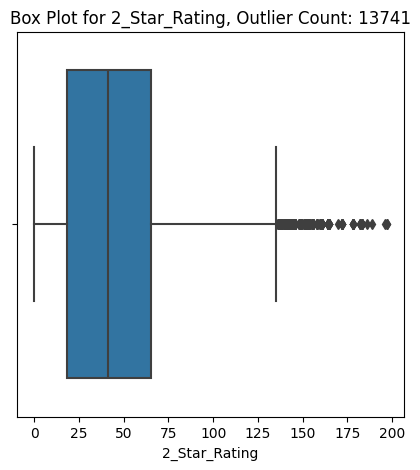

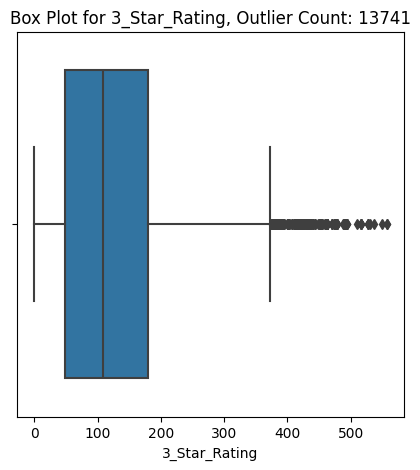

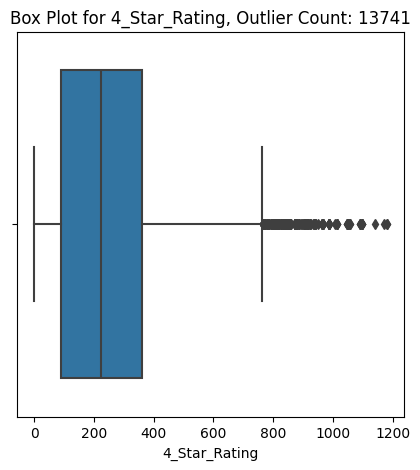

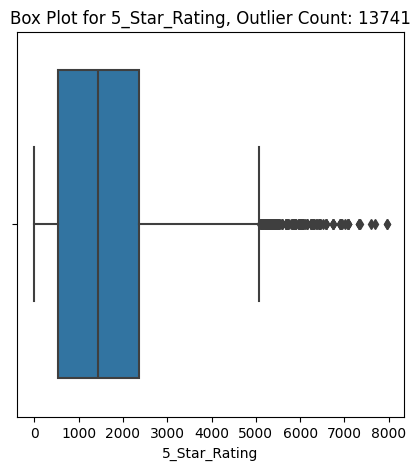

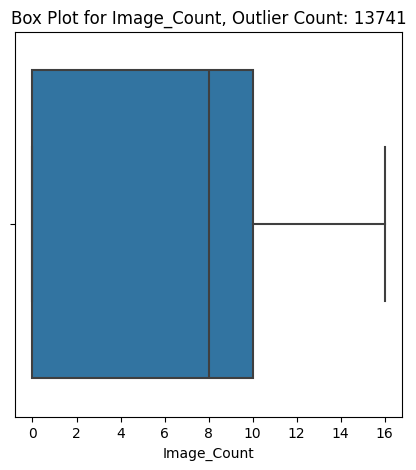

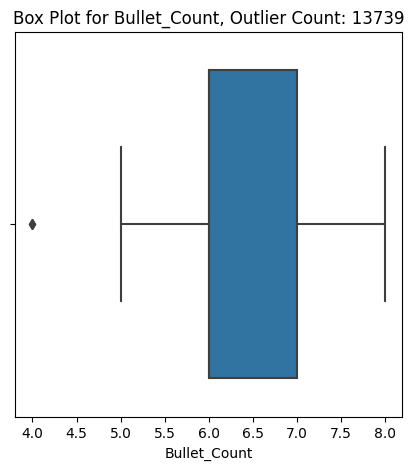

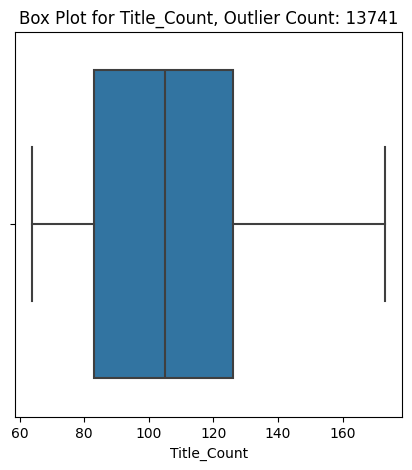

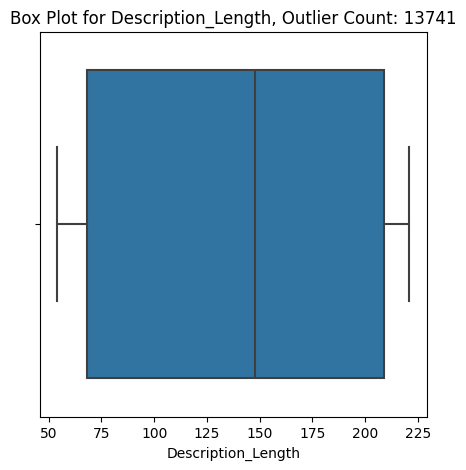

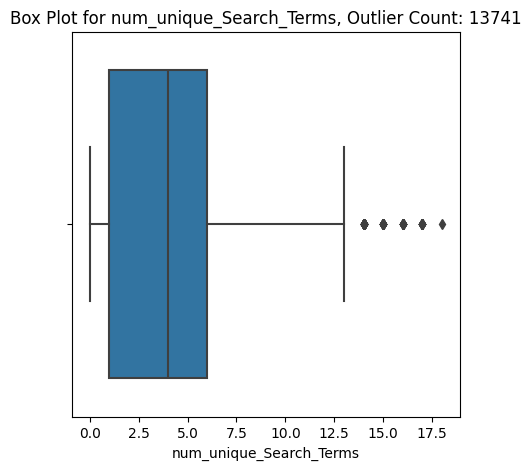

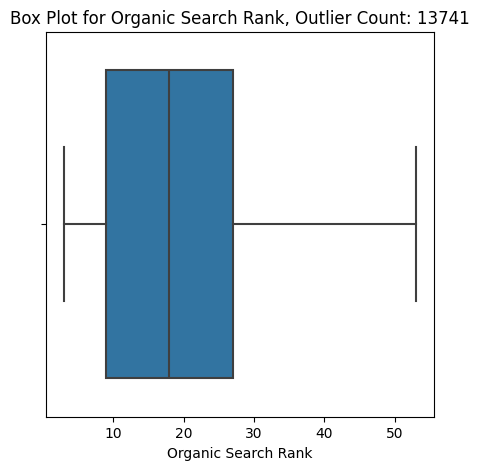

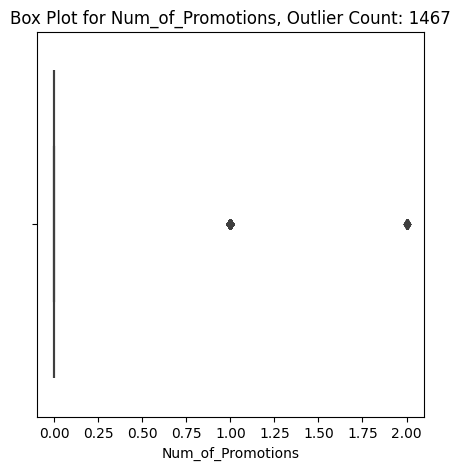

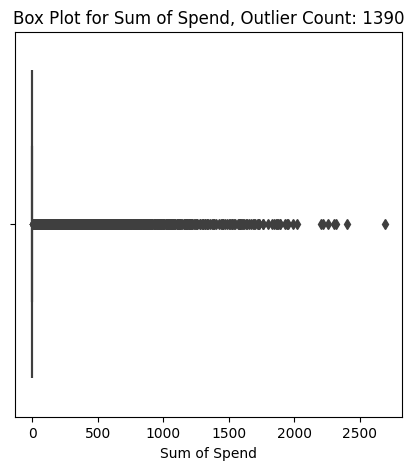

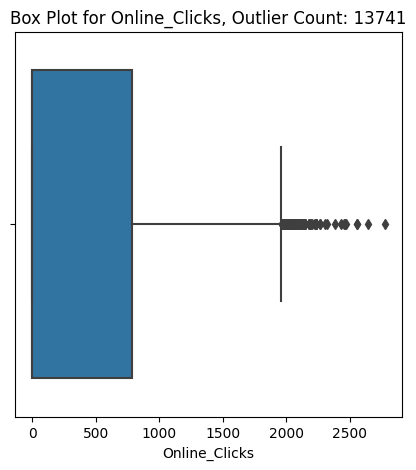

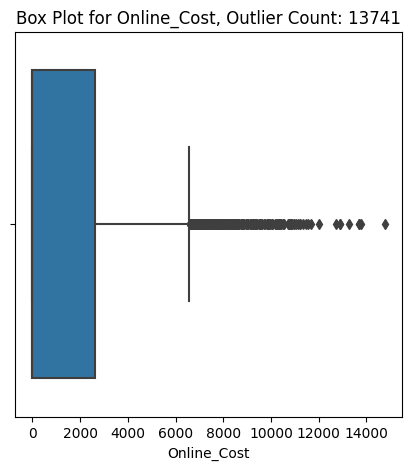

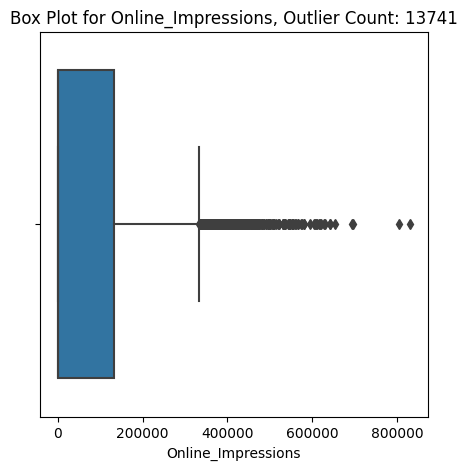

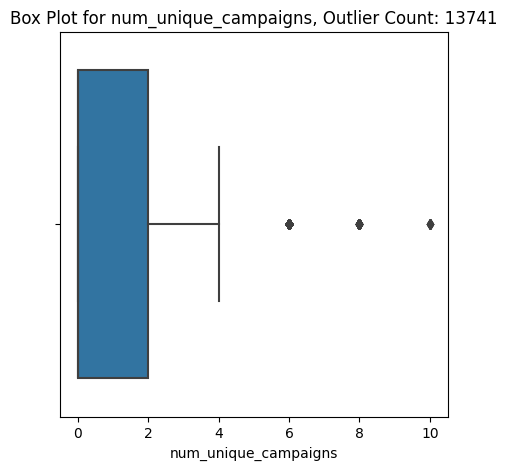

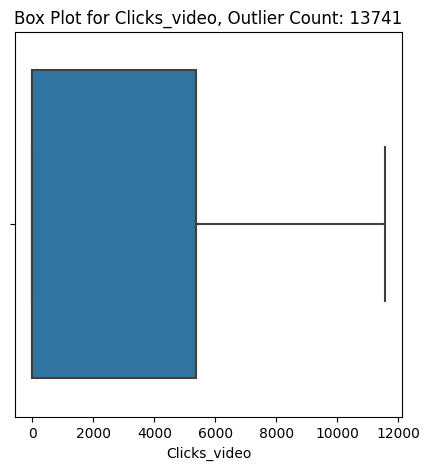

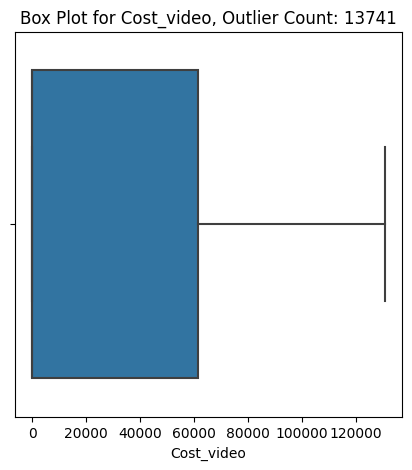

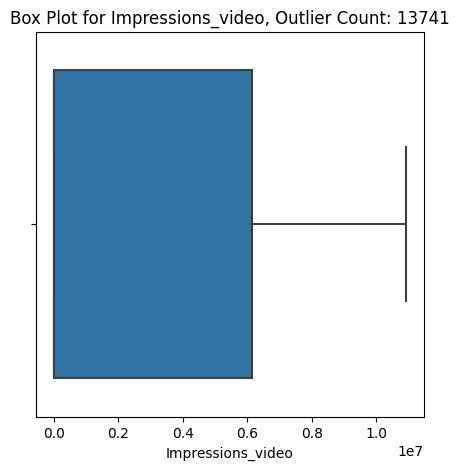

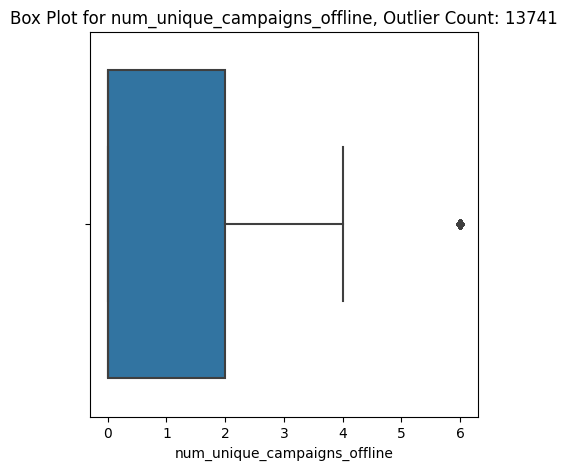

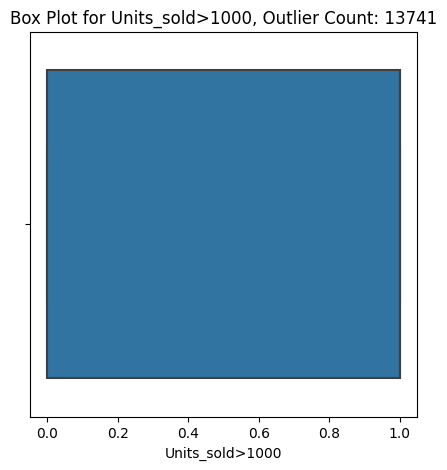

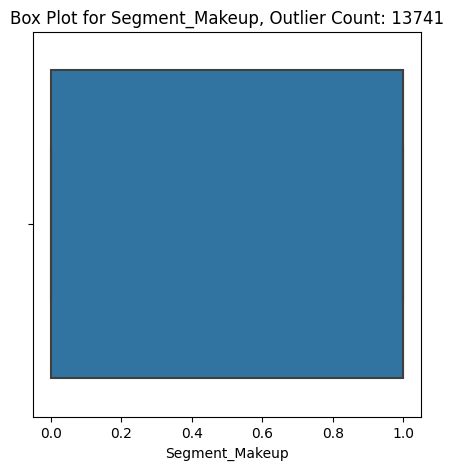

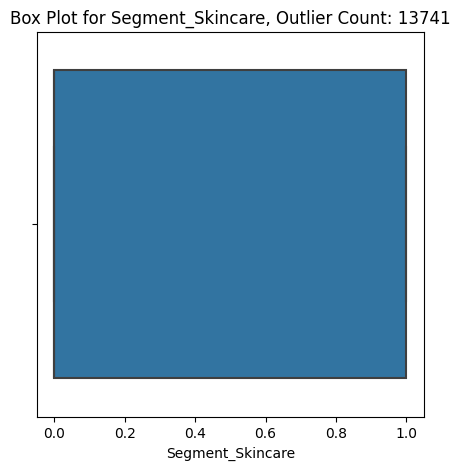

In [13]:
# iterate over each column in the training data
for col in df_train.columns:
    if pd.api.types.is_numeric_dtype(df_train[col]) and not pd.api.types.is_bool_dtype(df_train[col]):
        perc_25, perc_75, df_train[col] = handle_train_outliers(df_train,col)
        df_test[col] = handle_outliers(df_test,col,perc_25,perc_75)
        df_val[col] = handle_outliers(df_val,col,perc_25,perc_75)

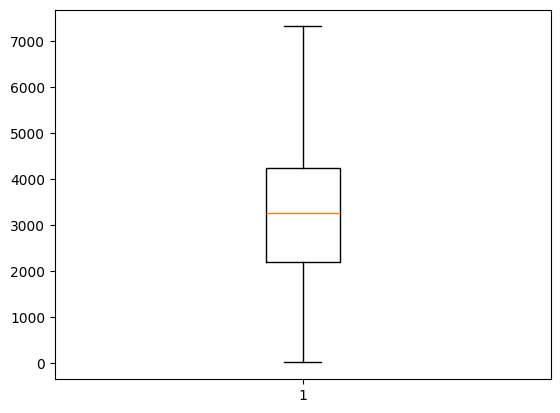

In [14]:
# Create the boxplot
plt.boxplot(df_train['Page_traffic'])
plt.show()

In [15]:
check_model_performance(df_train,df_val)

Performance on Train Data: 0.9408206831119544
Performance on Validation Data: 0.8935995060712081


We didn't scale the data as decision trees doesn't need scaling

### Video 4: Feature Generation

#### 1. Rating Column

In [16]:
# Select all columns from df_train tha tcontain the string 'Star_Rating'
rating_cols = df_train.columns[df_train.columns.str.contains('Star_Rating')]
rating_cols

Index(['1_Star_Rating', '2_Star_Rating', '3_Star_Rating', '4_Star_Rating',
       '5_Star_Rating'],
      dtype='object')

In [17]:
average_rating_calc = lambda x: np.round(
                                sum([i * val for i,val in enumerate(x,start=1)]) /(sum(x) + 1e-15)
                                ,1)


In [18]:
df_train['average_rating'] = df_train[rating_cols].apply(average_rating_calc,axis=1)
df_val['average_rating'] = df_val[rating_cols].apply(average_rating_calc,axis=1)
df_test['average_rating'] = df_test[rating_cols].apply(average_rating_calc,axis=1)

In [19]:
df_train.average_rating.describe()

count    13741.000000
mean         3.908733
std          1.548162
min          0.000000
25%          4.500000
50%          4.600000
75%          4.600000
max          4.900000
Name: average_rating, dtype: float64

In [20]:
check_model_performance(df_train,df_val)

Performance on Train Data: 0.9394154537924506
Performance on Validation Data: 0.8915016501650165


### 2. Online Cost Per Impression

In [21]:
df_train['online_cost_per_impression'] = df_train['Online_Cost'] / (df_train['Online_Impressions'] + 1)
df_val['online_cost_per_impression'] = df_val['Online_Cost'] / (df_val['Online_Impressions'] + 1)
df_test['online_cost_per_impression'] = df_test['Online_Cost'] / (df_test['Online_Impressions'] + 1)

### 3. Video Cost Per Impression

In [22]:
df_train['video_cost_per_impression'] = df_train['Cost_video']/(df_train['Impressions_video']+1)
df_val['video_cost_per_impression'] = df_val['Cost_video']/(df_val['Impressions_video']+1)
df_test['video_cost_per_impression'] = df_test['Cost_video']/(df_test['Impressions_video']+1)

### 4. Total Cost

In [23]:
df_train['total_cost'] = df_train['Online_Cost'] + df_train['Cost_video']
df_val['total_cost'] = df_val['Online_Cost'] + df_val['Cost_video']
df_test['total_cost'] = df_test['Online_Cost'] + df_test['Cost_video']

In [24]:
check_model_performance(df_train,df_val)

Performance on Train Data: 0.9390323538141881
Performance on Validation Data: 0.8937834499794154


### 5. Total Clicks

In [25]:
df_train['total_clicks'] = df_train['Online_Clicks'] + df_train['Clicks_video']
df_val['total_clicks'] = df_val['Online_Clicks'] + df_val['Clicks_video']
df_test['total_clicks'] = df_test['Online_Clicks'] + df_test['Clicks_video']

### 6. Feature Engineering with Dates

In [26]:
df_train['Date'].head()

0    2022-08-13
1    2021-06-12
2    2022-10-29
3    2022-03-19
4    2021-01-23
Name: Date, dtype: object

In [27]:
# Convert 'Date' column from string format to datetime objects
df_train['Date'] = pd.to_datetime(df_train.Date, format="%Y-%m-%d")
df_test['Date'] = pd.to_datetime(df_test.Date, format="%Y-%m-%d")
df_val['Date'] = pd.to_datetime(df_val.Date, format="%Y-%m-%d")

In [28]:
df_train['month'] = df_train.Date.dt.month
df_test['month'] = df_test.Date.dt.month
df_val['month'] = df_val.Date.dt.month

In [29]:
df_train['is_month_end'] = df_train.Date.dt.is_month_end * 1
df_test['is_month_end'] = df_test.Date.dt.is_month_end * 1
df_val['is_month_end'] = df_val.Date.dt.is_month_end * 1

In [30]:
check_model_performance(df_train,df_val)

Performance on Train Data: 0.9462876135082201
Performance on Validation Data: 0.8972389454017023


### Drop Irrelevant Columns and Split data into x and y

In [32]:
x_train = df_train.drop(['SKU_ID','Date','Revenue($)','Units_sold','Units_sold>1000'],axis=1)
y_train = df_train['Units_sold>1000']

x_val = df_val.drop(['SKU_ID','Date','Revenue($)','Units_sold','Units_sold>1000'],axis=1)
y_val = df_val['Units_sold>1000']

x_test = df_test.drop(['SKU_ID','Date','Revenue($)','Units_sold','Units_sold>1000'],axis=1)
y_test = df_test['Units_sold>1000']

In [33]:
# Create the final model
model_feature_eng = GradientBoostingClassifier(max_depth=9,min_samples_leaf=30,n_estimators=50, random_state=42)

model_feature_eng.fit(x_train,y_train)

# Making predictions for validation data
y_pred_train = model_feature_eng.predict(x_train)

# Making predictions for validation data
y_pred_val = model_feature_eng.predict(x_val)

f1_train = f1_score(y_train,y_pred_train)
f1_val = f1_score(y_val,y_pred_val)

print('F1 Score on training data:', f1_train)
print('F1 Score on validation data:', f1_val)

F1 Score on training data: 0.9462876135082201
F1 Score on validation data: 0.8972389454017023


## Video 5. Feature Selection

### Forward Selection

In [34]:
# Create new version of the data
x_train_fs = df_train.drop(['SKU_ID','Date','Revenue($)','Units_sold','Units_sold>1000'],axis=1)
y_train_fs = df_train['Units_sold>1000']

x_val_fs = df_val.drop(['SKU_ID','Date','Revenue($)','Units_sold','Units_sold>1000'],axis=1)
y_val_fs = df_val['Units_sold>1000']

x_test_fs = df_test.drop(['SKU_ID','Date','Revenue($)','Units_sold','Units_sold>1000'],axis=1)
y_test_fs = df_test['Units_sold>1000']

In [35]:
# import relevant libraries
from sklearn.feature_selection import SequentialFeatureSelector

In [36]:
# Create the model constructor
model_feature_eng = GradientBoostingClassifier(max_depth=9,min_samples_leaf=30,n_estimators=50, random_state=42)

*Rule* - If the mean f1 score of a model doesn't increase by 0.005 after addomg a new feature, we will not select that feature.

In [37]:
forward_selection = SequentialFeatureSelector(model_feature_eng,n_features_to_select='auto',
                                              tol=0.005,
                                              direction='forward',
                                              scoring='f1',
                                              cv=3,n_jobs=-1)

In [38]:
forward_selection.fit(x_train_fs,y_train_fs)

SequentialFeatureSelector(cv=3,
                          estimator=GradientBoostingClassifier(max_depth=9,
                                                               min_samples_leaf=30,
                                                               n_estimators=50,
                                                               random_state=42),
                          n_jobs=-1, scoring='f1', tol=0.005)

In [39]:
# Get the masked names of the selected columns
selected_fs_mask = forward_selection.get_support()

# Get the exact name of the selected columns
selected_fs_names = x_train_fs.columns[selected_fs_mask]

print(f'Selected Features:')
print(selected_fs_names)

Selected Features:
Index(['Page_traffic', 'Unit_price', '4_Star_Rating', 'Title_Count',
       'Description_Length', 'month'],
      dtype='object')


In [40]:
# Modify the dataframe
x_train_fs = df_train.loc[:,selected_fs_names]
y_train_fs = df_train['Units_sold>1000']

x_val_fs = df_val.loc[:,selected_fs_names]
y_val_fs = df_val['Units_sold>1000']

x_test_fs = df_test.loc[:,selected_fs_names]
y_test_fs = df_test['Units_sold>1000']

In [41]:
# Get model performance
model_feature_eng.fit(x_train_fs,y_train_fs)

# Making predictions for Train data
y_pred_train_fs = model_feature_eng.predict(x_train_fs)

# Making predictions for validation data
y_pred_val_fs = model_feature_eng.predict(x_val_fs)

f1_train_new = f1_score(y_train_fs,y_pred_train_fs)
f1_val_new = f1_score(y_val_fs,y_pred_val_fs)

print('F1 Score on training data:', f1_train_new)
print('F1 Score on validation data:', f1_val_new)


F1 Score on training data: 0.917706319920342
F1 Score on validation data: 0.8842450317557877


### Backward Selection

In [42]:
# Create new version of the data
x_train_bs = df_train.drop(['SKU_ID','Date','Revenue($)','Units_sold','Units_sold>1000'],axis=1)
y_train_bs = df_train['Units_sold>1000']

x_val_bs = df_val.drop(['SKU_ID','Date','Revenue($)','Units_sold','Units_sold>1000'],axis=1)
y_val_bs = df_val['Units_sold>1000']

x_test_bs = df_test.drop(['SKU_ID','Date','Revenue($)','Units_sold','Units_sold>1000'],axis=1)
y_test_bs = df_test['Units_sold>1000']

In [43]:
backward_selection = SequentialFeatureSelector(model_feature_eng,n_features_to_select='auto',
                                              tol=0.005,
                                              direction='backward',
                                              scoring='f1',
                                              cv=3,n_jobs=-1)

In [45]:
backward_selection.fit(x_train_bs,y_train_bs)

SequentialFeatureSelector(cv=3, direction='backward',
                          estimator=GradientBoostingClassifier(max_depth=9,
                                                               min_samples_leaf=30,
                                                               n_estimators=50,
                                                               random_state=42),
                          n_jobs=-1, scoring='f1', tol=0.005)

In [46]:
# Get the masked names of the selected columns
selected_bs_mask = backward_selection.get_support()

# Get the exact name of the selected columns
selected_bs_names = x_train_bs.columns[selected_bs_mask]

print(f'Selected Features:')
print(selected_bs_names)

Selected Features:
Index(['Page_traffic', 'Unit_price', '2_Star_Rating', '3_Star_Rating',
       '4_Star_Rating', '5_Star_Rating', 'Image_Count', 'Bullet_Count',
       'Title_Count', 'Description_Length', 'num_unique_Search_Terms',
       'Organic Search Rank', 'Num_of_Promotions', 'Sum of Spend',
       'Online_Clicks', 'Online_Cost', 'Online_Impressions',
       'num_unique_campaigns', 'Clicks_video', 'Cost_video',
       'Impressions_video', 'num_unique_campaigns_offline', 'Segment_Makeup',
       'Segment_Skincare', 'average_rating', 'online_cost_per_impression',
       'video_cost_per_impression', 'total_cost', 'total_clicks', 'month',
       'is_month_end'],
      dtype='object')


In [47]:
# Modify the dataframe
x_train_bs = df_train.loc[:,selected_bs_names]
y_train_bs = df_train['Units_sold>1000']

x_val_bs = df_val.loc[:,selected_bs_names]
y_val_bs = df_val['Units_sold>1000']

x_test_bs = df_test.loc[:,selected_bs_names]
y_test_bs = df_test['Units_sold>1000']

In [48]:
# Get model performance
model_feature_eng.fit(x_train_bs,y_train_bs)

# Making predictions for Train data
y_pred_train_bs = model_feature_eng.predict(x_train_bs)

# Making predictions for validation data
y_pred_val_bs = model_feature_eng.predict(x_val_bs)

f1_train_new1 = f1_score(y_train_bs,y_pred_train_bs)
f1_val_new1 = f1_score(y_val_bs,y_pred_val_bs)

print('F1 Score on training data:', f1_train_new1)
print('F1 Score on validation data:', f1_val_new1)

F1 Score on training data: 0.9467203409898176
F1 Score on validation data: 0.8958677685950414


### Embedded Method Tree - Based Model

In [49]:
# Create a new version of the data
x_train_em = df_train.drop(['SKU_ID','Date','Revenue($)','Units_sold','Units_sold>1000'],axis=1)
y_train_em = df_train['Units_sold>1000']

x_val_em = df_val.drop(['SKU_ID','Date','Revenue($)','Units_sold','Units_sold>1000'],axis=1)
y_val_em = df_val['Units_sold>1000']

x_test_em = df_test.drop(['SKU_ID','Date','Revenue($)','Units_sold','Units_sold>1000'],axis=1)
y_test_em = df_test['Units_sold>1000']

In [50]:
model_feature_eng = GradientBoostingClassifier(max_depth=9,min_samples_leaf=30,n_estimators=50, random_state=42)

In [51]:
model_feature_eng.fit(x_train_em,y_train_em)

GradientBoostingClassifier(max_depth=9, min_samples_leaf=30, n_estimators=50,
                           random_state=42)

In [52]:
feature_importance = pd.DataFrame({
    'Feature':x_train_em.columns,
    'Importance':model_feature_eng.feature_importances_
})

In [53]:
# Sorting the dataframe
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

feature_importance['cumulative'] = feature_importance.Importance.cumsum()
feature_importance

,Feature,Importance,cumulative
0,Page_traffic,0.361540,0.361540
1,Unit_price,0.127385,0.488925
9,Title_Count,0.072428,0.561354
10,Description_Length,0.058299,0.619652
7,Image_Count,0.049410,0.669062
30,month,0.042474,0.711537
2,1_Star_Rating,0.037283,0.748820
6,5_Star_Rating,0.022691,0.771511
3,2_Star_Rating,0.022148,0.793659
4,3_Star_Rating,0.020125,0.813784


In [55]:
# get the selected features
selected_features = feature_importance[:-9].Feature.tolist()
selected_features

['Page_traffic',
 'Unit_price',
 'Title_Count',
 'Description_Length',
 'Image_Count',
 'month',
 '1_Star_Rating',
 '5_Star_Rating',
 '2_Star_Rating',
 '3_Star_Rating',
 'Organic Search Rank',
 '4_Star_Rating',
 'online_cost_per_impression',
 'num_unique_Search_Terms',
 'average_rating',
 'total_cost',
 'total_clicks',
 'num_unique_campaigns',
 'Online_Impressions',
 'Segment_Makeup',
 'Online_Cost',
 'Online_Clicks',
 'video_cost_per_impression']

In [56]:
# Modify the dataframe
x_train = df_train.loc[:,selected_features]
y_train = df_train['Units_sold>1000']

x_val = df_val.loc[:,selected_features]
y_val = df_val['Units_sold>1000']

x_test = df_test.loc[:,selected_features]
y_test = df_test['Units_sold>1000']

In [57]:
# Get model performance
model_feature_eng.fit(x_train,y_train)

# Making predictions for Train data
y_pred_train_ = model_feature_eng.predict(x_train)

# Making predictions for validation data
y_pred_val = model_feature_eng.predict(x_val)

f1_train_new = f1_score(y_train,y_pred_train)
f1_val_new = f1_score(y_val,y_pred_val)

print('F1 Score on training data:', f1_train_new)
print('F1 Score on validation data:', f1_val_new)

F1 Score on training data: 0.9462876135082201
F1 Score on validation data: 0.8964374482187241


In [58]:
# Combine data
train_new = pd.concat([x_train,y_train],axis=1)
test_new = pd.concat([x_test,y_test],axis=1)
val_new = pd.concat([x_val,y_val],axis=1)

# Export to csv
train_new.to_csv('train_new.csv', index=False)
test_new.to_csv('test_new.csv', index=False)
val_new.to_csv('val_new.csv', index=False)